# Predict rain based on other weather variables

This notebook will use time lags to train a machine learning model for predicting temprature. 

First, we select a random station. The data is kept at daily resolution. Then, we generate a lagged feature matrix.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import glob
from mpl_toolkits.basemap import Basemap

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
%%time
data_dir = '/datasets/NOAA_SST/'
#load(data_dir + “noaa_gsod/…/file”
t0 = time.time()
data = pd.read_pickle(data_dir+'noaa_gsod/Combined_noaa_gsod') # load weather data
stations = pd.read_pickle(data_dir+'noaa_gsod.stations') # load station data

# # USE ONLY 2008-2018 # #
data = data.loc[data.index >= pd.Timestamp(2008, 1, 1)]
data = data.drop(columns=['yr','year','da','mo']) # don't need these anymore
print(time.time()-t0)

25.82512664794922
CPU times: user 15.7 s, sys: 10.1 s, total: 25.9 s
Wall time: 25.8 s


In [4]:
stations.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
0,007018,99999,WXPOD 7018,None,None,None,0.00,0.000,+7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,None,None,0.00,0.000,+7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,None,None,0.00,0.000,+7070.0,20140923,20150926
3,008268,99999,WXPOD8278,AF,None,None,32.95,65.567,+1156.7,20100519,20120323
4,008307,99999,WXPOD 8318,AF,None,None,0.00,0.000,+8318.0,20100421,20100421


In [5]:
data.head()

,stn,temp,slp,wdsp,mxpsd,max,min,prcp
Datetime,,,,,,,,
2008-08-22,619970,41.7,1032.1,7.2,14.0,46.6,37.8,0.00
2008-09-28,714170,54.9,1023.8,9.1,15.0,70.3,51.4,0.06
2008-02-14,041560,35.6,1032.8,28.5,38.9,36.5,34.5,0.00
2008-02-25,041560,4.5,997.1,4.3,7.0,10.4,-1.1,0.00
2008-10-06,041650,43.3,998.8,24.3,30.9,44.6,40.3,0.00


In [6]:
data['stn'][:5]

Datetime
2008-08-22    619970
2008-09-28    714170
2008-02-14    041560
2008-02-25    041560
2008-10-06    041650
Name: stn, dtype: object

In [7]:
# # SELECT RANDOM STATION # #
np.random.seed(0)
rs = np.unique(data['stn'].values) # find unique stations with data
rand_stat = rs[randint(len(rs))] # pick a random station

In [8]:
rs[randint(len(rs))]

'983300'

In [9]:
# # SELECT RANDOM STATION # #
np.random.seed(0)
rs = np.unique(data['stn'].values) # find unique stations with data
rand_stat = rs[randint(len(rs))] # pick a random station

# # ideally we should check < len(np.unique(data.index)), but many are shorter
counter = 0
while (len(data.loc[data['stn'] == rand_stat]) < 3650): # If not enough data
            
    if len(stations.loc[stations['usaf'] == rand_stat]): # If station info available
        
        if (stations.loc[stations['usaf'] == rand_stat].iloc[0]['wban'] != '99999') or len(data.loc[data['stn']==rand_stat]) < 3650: # If station number not unique
            rand_stat = rs[randint(len(rs))] # get a new station
            if counter//100 == 0:
                print('first condition')
    else:
        rand_stat = rs[randint(len(rs))] # get a new station
        if counter//100 ==0:
            print('2nd condition')

select_station = stations.loc[stations['usaf'] == rand_stat] # get location, etc, for random station

features = data.loc[data['stn'] == rand_stat] # pick weather at random station
features = features.drop(columns='stn')
features = features.drop(columns='max')
features = features.drop(columns='min')
features = features.sort_index()
select_station.head() # see where it is

1 289520 1395
here
first condition
2 983300 3127
here
first condition


,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
21256,352170,99999,DZHAMBEJTY,KZ,None,None,50.25,52.567,+0032.0,19480101,20190401


### Time-shift the data

In [10]:
columns = features.columns 
for co in columns:
    # one day lag
    features[co + '_lag1'] = features[co].shift(periods=1)
    
    # two days lag
    features[co + '_lag2'] = features[co].shift(periods=2)
    
    # three days lag
    features[co + '_lag3'] = features[co].shift(periods=3)
features = features.iloc[3:]
print(str(len(features)) + ' samples, ' + str(len(features.columns)) + ' features.')
features.head()

3904 samples, 20 features.


,temp,slp,wdsp,mxpsd,prcp,temp_lag1,temp_lag2,temp_lag3,slp_lag1,slp_lag2,slp_lag3,wdsp_lag1,wdsp_lag2,wdsp_lag3,mxpsd_lag1,mxpsd_lag2,mxpsd_lag3,prcp_lag1,prcp_lag2,prcp_lag3
Datetime,,,,,,,,,,,,,,,,,,,,
2008-01-04,-4.0,1040.9,3.9,5.8,0.0,-4.1,4.2,1.4,1041.6,1031.1,1035.6,13.6,5.8,6.8,23.3,11.7,9.7,0.0,0.0,0.0
2008-01-05,-0.7,1039.9,4.2,7.8,0.0,-4.0,-4.1,4.2,1040.9,1041.6,1031.1,3.9,13.6,5.8,5.8,23.3,11.7,0.0,0.0,0.0
2008-01-06,4.2,1039.7,1.6,3.9,0.0,-0.7,-4.0,-4.1,1039.9,1040.9,1041.6,4.2,3.9,13.6,7.8,5.8,23.3,0.0,0.0,0.0
2008-01-07,8.7,1034.8,5.0,7.8,0.0,4.2,-0.7,-4.0,1039.7,1039.9,1040.9,1.6,4.2,3.9,3.9,7.8,5.8,0.0,0.0,0.0
2008-01-08,9.9,1028.2,8.7,11.7,0.0,8.7,4.2,-0.7,1034.8,1039.7,1039.9,5.0,1.6,4.2,7.8,3.9,7.8,0.0,0.0,0.0


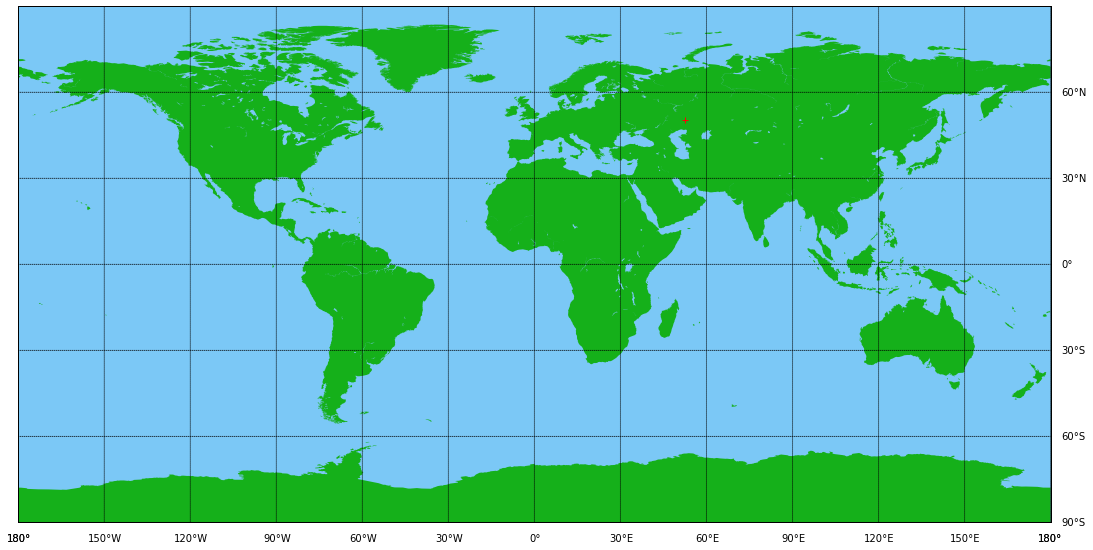

In [11]:
# Show the position of the station

fig = plt.figure(figsize=(18.5, 10.5))
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180, resolution='l')
m.drawmapboundary(fill_color='xkcd:lightblue')
m.fillcontinents(color='xkcd:green',lake_color='xkcd:lightblue')
m.drawmeridians(np.arange(-180.,180.,30.),labels=[True,False,False,True])
m.drawparallels(np.arange(-90.,90,30.),labels=[False,True,True,False])
lon = select_station['lon'].tolist()
lat = select_station['lat'].tolist()
m.plot(lon, lat,'r+') 
plt.show()

### Create train/val/test

In [12]:
ylabel = features['temp'] # use today's temperature as the label
features = features.drop(columns='temp') # don't put it in training data!!

# Use 20% test split (80% training + validation)
ntrain = int(len(features)*0.8)
x_test = features.iloc[ntrain:,:]
y_test = ylabel[ntrain:]
indices = np.arange(ntrain)

# Split remaining 80% into training-validation sets (of original data)
x_train, x_val, y_train, y_val, train_ind, test_ind = train_test_split(features.iloc[0:ntrain,:], ylabel[0:ntrain], indices, test_size=0.2, random_state=1)

# Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

### Predict with Random Forest

In [77]:
# # Create, train, and predict random forest here # #

rf_reg = RandomForestRegressor(n_estimators = 1000,min_samples_leaf=5)
rf_reg.fit(x_train,y_train)

y_pred_test = rf_reg.predict(x_test)
y_pred_val  = rf_reg.predict(x_val)
y_pred_train = rf_reg.predict(x_train)

In [73]:
ntrain

3123

### Plot random forest

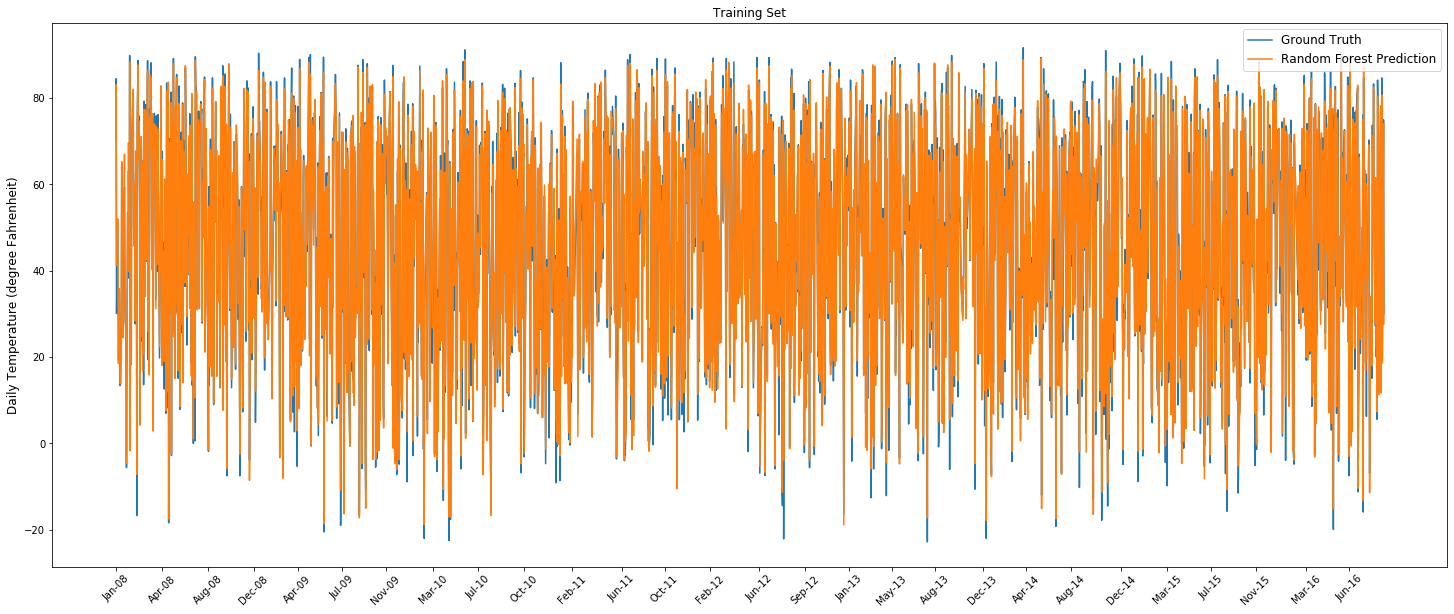

training R^2 Score: 0.9849574770524869


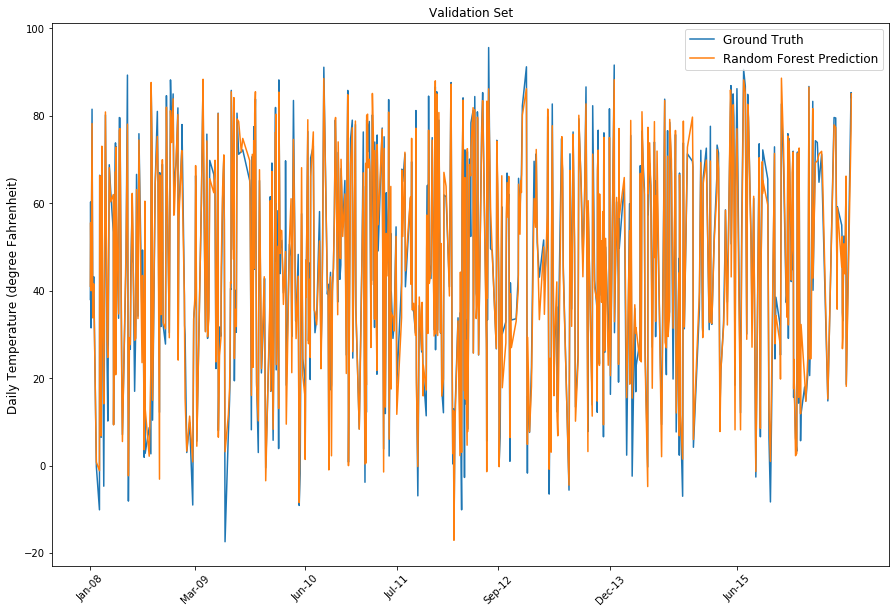

validation R^2 Score: 0.9588466147034835


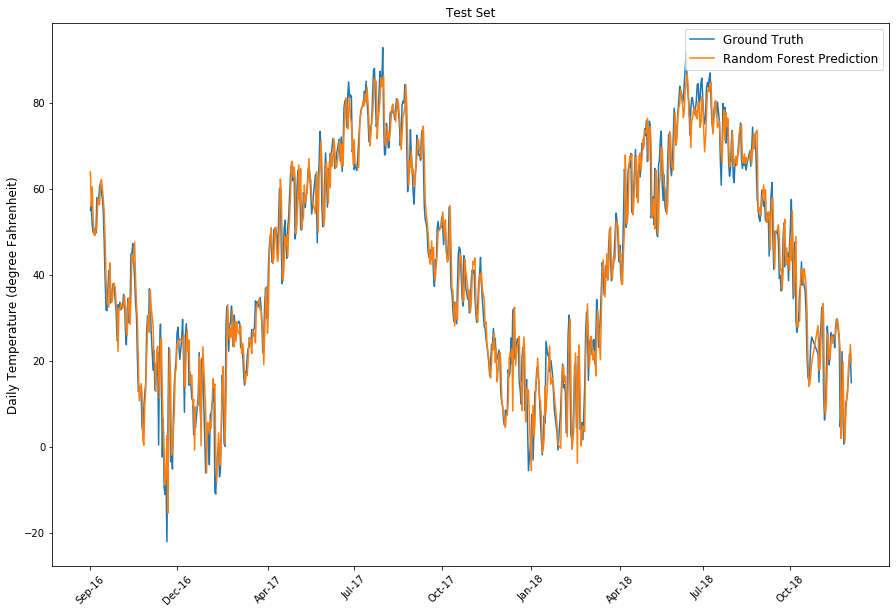

test R^2 Score: 0.9471094330812182


In [78]:
# plot predictions

# Training Set
plt.figure(figsize=(25,10))
plt.plot(features.iloc[train_ind].sort_index().index,y_train) # plot actual temperature
plt.plot(features.iloc[train_ind].sort_index().index,y_pred_train) # plot predicted temperature
plt.legend(('Ground Truth','Random Forest Prediction'), fontsize=12, loc=1)
myFmt = mdates.DateFormatter('%b-%y') # This shows day-month-year. Switch to month-year or annually
plt.xticks(features.iloc[train_ind].sort_index().index[::90], rotation = 45) # set xticks to monthly
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Daily Temperature (degree Fahrenheit)', fontsize=12)
plt.title('Training Set')
plt.show()
print('training R^2 Score:',rf_reg.score(x_train,y_train))

# Validation set
plt.figure(figsize=(15,10))
plt.plot(features.iloc[test_ind].sort_index().index,y_val) # plot actual temperature
plt.plot(features.iloc[test_ind].sort_index().index,y_pred_val) # plot predicted temperature
plt.legend(('Ground Truth','Random Forest Prediction'), fontsize=12, loc=1)
myFmt = mdates.DateFormatter('%b-%y') # This shows day-month-year. Switch to month-year or annually
plt.xticks(features.iloc[test_ind].sort_index().index[::90], rotation = 45) # set xticks to monthly
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Daily Temperature (degree Fahrenheit)', fontsize=12)
plt.title('Validation Set')
plt.show()
print('validation R^2 Score:',rf_reg.score(x_val,y_val))

# Test Set
plt.figure(figsize=(15,10))
plt.plot(features.iloc[ntrain:].index,y_test) # plot actual temperature
plt.plot(features.iloc[ntrain:].index,y_pred_test) # plot predicted temperature
plt.legend(('Ground Truth','Random Forest Prediction'), fontsize=12, loc=1)
plt.xticks(features.iloc[ntrain:].index[::90], rotation = 45) # set xticks to monthly
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Daily Temperature (degree Fahrenheit)', fontsize=12)
plt.title('Test Set')
plt.show()
print('test R^2 Score:',rf_reg.score(x_test,y_test))




TRAIN SET

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


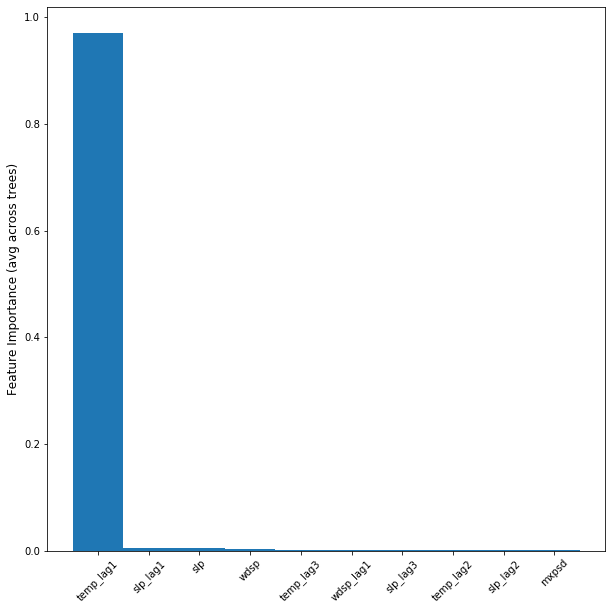

In [79]:

# # Plot the feature importances # #
nfeatures = 10
plt.figure(figsize = (10,10))
fi = rf_reg.feature_importances_ # get feature importances
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[[fi_sort[0:nfeatures]]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

### Feature importance is the weighted impurity of a branch adjusted by its children nodes and normalized by the impurities of all branches. The Random Forest feature importances are averaged over all regression trees.

# Analysis

Because the random forests place such large importance on the previous day's temperature: temp_lag1, we are not gaining much information from the other variables are and they are not useful features. This led me to look closer at the test data, as my suspicion is that the model is learning a delay method, where it essentially predicts the previous days temperature. If that is the case, then we are not really learning anything in the model, and instead it is just predicting the previous days temperature in order to minimize loss. As evidenced in the plot below, where we look at a zoomed in chunk of the test set, we see clearly see that the model prediction looks close to the delayed ground truth model, although perfectly, which leads me to believe that our model has learned a largely delay based approach where it predicts the previous days temperature.

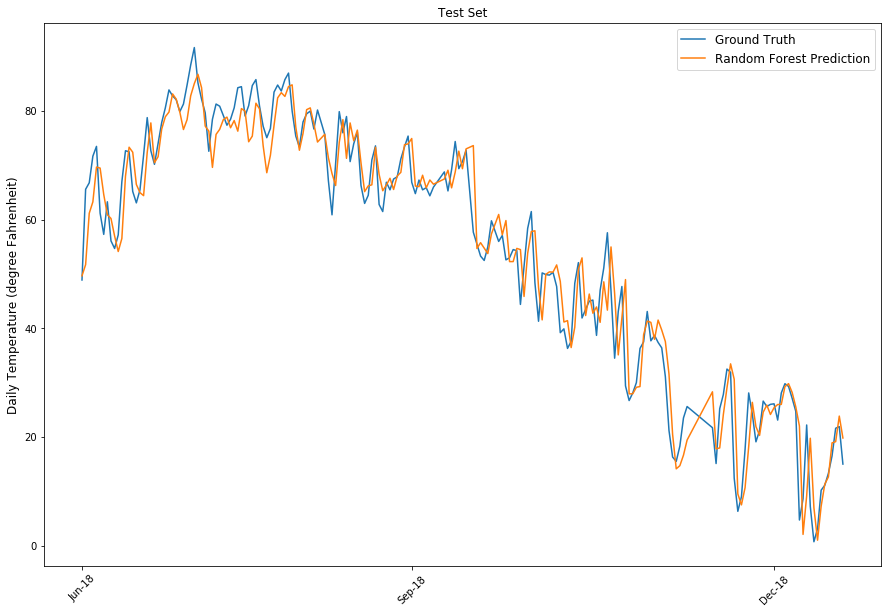

test R^2 Score: 0.9471094330812182


In [87]:
# Test Set
plt.figure(figsize=(15,10))
plt.plot(features.iloc[-200:].index,y_test[-200:]) # plot actual temperature
plt.plot(features.iloc[-200:].index,y_pred_test[-200:]) # plot predicted temperature
plt.legend(('Ground Truth','Random Forest Prediction'), fontsize=12, loc=1)
plt.xticks(features.iloc[-200:].index[::90], rotation = 45) # set xticks to monthly
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Daily Temperature (degree Fahrenheit)', fontsize=12)
plt.title('Test Set')
plt.show()
print('test R^2 Score:',rf_reg.score(x_test,y_test))

3123